# Twitter ETL & Sentiment Analysis

## Overview

The goal of this post is to demonstrate how we can use Twitter's API & Python's primary natural-language processing (NLP) libraries to easily analyze the overall sentiment of recent tweets on any given subject. 

Additionally, I'll show how to load this data into a SQL database or S3 bucket on AWS. This type of ETL or data pipeline would likely be necessary in the case that I wanted to continously maintain and analyze a larger list of tweets over time, or in a professional setting where multiple analysts and engineers need to access to the data.

The code and analysis below will cover the following topics:
- Extracting tweets from the Twitter API using a Python library called Tweepy
- Transforming the tweets data into a pandas dataframe for ease of analysis
- Cleaning and pre-processing unstructured, unlabeled text data
- Loading the cleaned, tweet dataframe into a SQL database or Amazon S3 bucket.
- Executing sentiment analysis using libraries like scikit-learn and transformers

The source code can be found in my GitHub profile [here]().

## *1) Setup*


In [22]:
### Load libraries

# Twitter
import tweepy

# Data analysis
import pandas as pd
import numpy as np
pd.set_option('display.width', 1000)

# SQL
import sqlite3

# Regex
import re

# Environment variables
from decouple import config

# AWS S3 Upload
from datetime import date
import boto3
import io

# Text analytics
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
import altair as alt
from textblob import TextBlob
from transformers import pipeline, set_seed

# Configure environment variables
BEARER_TOKEN = config('BEARER_TOKEN')
AWS_ACCESS_KEY_ID = config('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = config('AWS_SECRET_ACCESS_KEY')

# Warnings
import warnings
warnings.filterwarnings('ignore')

The last few lines of code above relates to the environment variables I have stored in a separate .env file. These include my Twitter API bearer token as well as my AWS credentials. Using the python-decouple library, I can simply assign this confidential information to new local variables in this file. In managing the bearer token and AWS keys this way, I'm able to make requests to the Twitter API, upload data to AWS, share my source code, and keep my accounts secure.

I highly recommend [this article](https://able.bio/rhett/how-to-set-and-get-environment-variables-in-python--274rgt5) for a quick example of how to use python-decouple for this use case.  

## *2) Extract*

First I will initialize the tweepy client with my bearer_token. A bearer token is a type of authentication access token used for the OAuth 2.0 protocol. In simpler terms, it's a unique string that helps Twitter associate the API requests I make with my Twitter Developer account. 

Next, I define the query (term to search for on Twitter) as 'USMNT', an acronym for the United States Men's National Soccer Team. US Soccer has underwent significant internal turmoil since the 2022 World Cup. As a lifelong, die-hard fan of the team, I want to know how people feel about the resignation of two major executives, as the investigation into former manager, Gregg Berhalter. I also will specify in the query that I only want to see tweets in english and retweets should be excluded.

Using the search_recent_tweets Tweepy function, along with my defined twitter_query, I can start extracting relevant tweets. I'll also include the following parameters:
- tweet_fields: a list of tweet-specific fields I want be to be returned for each matching tweet object. 
- user_fields: a list of user-specific fields I want to be returned for each matching tweet object.
- max_results: the number of matching tweets to be returned. This number defaults to 10 and is capped at 100.

The Tweepy client then makes a HTTP request to the search_recent_tweets endpoint (https://api.twitter.com/2/tweets/search/recent). Assuming I have passed in a valid bearer_token and the parameters I included adhere to the Twitter API & Tweepy documentation, the endpoint will return a list of 100 tweet objects.


In [23]:
# Initialize Tweepy client with bearer_token
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Build twitter query - lowercase string, ensure no retweets are included, limit to english
twitter_query = "USMNT -is:retweet lang: en"

# Get tweets and save to new 'tweets' object
tweets = client.search_recent_tweets(query=twitter_query,
                                    tweet_fields=['context_annotations','created_at', 'public_metrics', 'possibly_sensitive', 'source'],
                                     user_fields=['username'],
                                     max_results=100)

# Extract the actual tweet data from the Tweepy tweets object
tweets_data = tweets.data

Next, I'll inspect the tweet attributes I'm interested in for the first 3 tweets. These are:
- created_at - time of tweet
- text - tweet contents) 
- public_metrics - public tweet metrics: number of retweets, replies, likes and quotes) 
- possibly_sensitive - a flag used to identify any potentially sensitive tweets
- source - how the tweet was created (phone, desktop, etc.)


In [24]:
# Loop through tweets_data and print results
for number, each in enumerate(tweets_data[0:3]):
    print(f" \
            Tweet {number} time: {each.created_at}\n \
            Tweet {number} text: {each.text.strip()}\n \
            Tweet {number} metrics: {each.public_metrics}\n \
            Tweet {number} possibily_sensitive?:  {each.possibly_sensitive}\n \
            Tweet {number} source: {each.source}\n")

             Tweet 0 time: 2023-01-30 14:25:46+00:00
             Tweet 0 text: @WVSoccerdad I would not include Ream simply because he has played the most minutes of anyone in the EPL. He will need/deserve a break. His club will need him more for the stretch run than the USMNT in March. I would bring Trusty to get a look at him.
             Tweet 0 metrics: {'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0, 'impression_count': 3}
             Tweet 0 possibily_sensitive?:  False
             Tweet 0 source: None

             Tweet 1 time: 2023-01-30 14:23:12+00:00
             Tweet 1 text: 🚨 New Pod now available!

The Pod Squad returns to give updates on everything major going on in US Soccer! On this new episode, Jake, Tom, and Ellie break down:

🔀 McKennie transfer to @LUFC 

‼️ Shakeups at USSF

🇺🇸🇷🇸🇨🇴 #USMNT Matches

Don’t miss out:

https://t.co/BhK4i9Ywvi
             Tweet 1 metrics: {'retweet_count': 1, 'reply_count': 1, 'like_count': 1, 'quote_count

## *3) Transform*

Its important to note that the data returned from the Twitter API comes in JSON format, which is not the same as tabular data.

For example, the 'tweets' object contains the following objects:
- data - a list of tweets and the attributes I printed above
- meta - Metadata such as newest tweet id in the response, oldest tweet id in the response, number of results returned, and the next token/page of tweets.

The data cannot be easily analyzed in it's current form (at least not using pandas). Therefore, I'll now execute a series of steps designed to clean and transform the data into a structure that's easier to work with: a dataframe.

To do this, I use list comprehension, which allows me to iterate through the list of tweets, saving each tweet value I care about to a new vector. Then I combine the 5 vectors into a pandas dataframe, which is printed below.


In [25]:
# Save results in dataframe
tweet_id = [each["id"] for each in tweets_data]
tweets = [each["text"] for each in tweets_data]
metrics = [each["public_metrics"] for each in tweets_data] 
sensitive = [each["possibly_sensitive"] for each in tweets_data] 
source = [each["source"] for each in tweets_data] 

# Save to df
df = pd.DataFrame({
    "tweet_id":tweet_id,
    "tweets":tweets,
    "metrics":metrics,
    "sensitive":sensitive,
    "source":source
      
})

# Inspect
df.head()

,tweet_id,tweets,metrics,sensitive,source
0,1620065740530548738,@WVSoccerdad I would not include Ream simply b...,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",False,None
1,1620065093433311232,🚨 New Pod now available!\n\nThe Pod Squad retu...,"{'retweet_count': 1, 'reply_count': 1, 'like_c...",False,None
2,1620064839526940673,USMNT World Cup predictions for all matches in...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",False,None
3,1620064506306256896,@USMNT @ATT We need better players.,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",False,None
4,1620064331076608001,"OTD one year ago, @SamAdekugbe capped off an i...","{'retweet_count': 3, 'reply_count': 3, 'like_c...",False,None


This isn't quite what I need, because the public_metrics values were stored as a dictionary and therefore not in separate columns in the dataframe. Below, I'll update the dataframe to fix this issue.


In [26]:
# Separate metrics dictionary to columns
metrics_cols = df["metrics"].apply(pd.Series)

# Add metrics columns to df
df = df.join(metrics_cols)

# Drop original metrics column
df = df.drop(columns=["metrics"])

# Inspect
df.head()

,tweet_id,tweets,sensitive,source,retweet_count,reply_count,like_count,quote_count,impression_count
0,1620065740530548738,@WVSoccerdad I would not include Ream simply b...,False,None,0,1,0,0,3
1,1620065093433311232,🚨 New Pod now available!\n\nThe Pod Squad retu...,False,None,1,1,1,0,134
2,1620064839526940673,USMNT World Cup predictions for all matches in...,False,None,0,0,0,0,0
3,1620064506306256896,@USMNT @ATT We need better players.,False,None,0,0,0,0,1
4,1620064331076608001,"OTD one year ago, @SamAdekugbe capped off an i...",False,None,3,3,11,0,4060


That looks better. I'll now proceed with cleaning the actual text data to remove unnecessary characters contained in the tweet.

First, I create a function utilizing the re (regex) library to remove the irrelevant content from the tweet (e.g. twitter handles and mentions, included links, non-letter characters). I then apply this function to each value in the "tweets" column of the dataframe.


In [27]:
# Clean tweets
def process_tweets(t):
    t = t.lower()
    t = re.sub("rt ", "", t)            # remove "rt", a term automatically left in if the tweet is a retweet
    t = re.sub("@[A-Za-z0-9]+", "", t) # remove handles
    t = re.sub("#[A-Za-z0-9]+", "", t) # remove hashtags
    t = re.sub(r"http\S+", "", t)      # remove links (anything that doesn't have a space after http)
    t = re.sub(r"www.\S+", "", t)      # remove links
    t = re.sub("[()!?]", "", t)        # remove punctuation
    t = re.sub("\[.*?\]", "", t)       # remove puncutation
    t = re.sub("[^a-z]", " ", t)       # remove anything that is not a letter
    return t

# Apply function to tweets
df["tweets"] = df["tweets"].apply(process_tweets)

Now we can look at the cleaned text data, sorted by number of retweets to get a better sense of what people are tweeting about our topi.


In [31]:
# Inspect tweets with most retweets
retweets = df.sort_values(by=["retweet_count"], ascending=False)

# Print 10 top most retweeted tweets
pd.set_option('max_colwidth', -1)
retweets[["tweets", "retweet_count"]][0:10]

,tweets,retweet_count
4,otd one year ago capped off an incredible day for the as les rouges recorded an unforgettable victory over the in hamilton,3
27,icymi vazquez continues to raise stock in nd appearance saturday night scored the lone goal of the us january camp,2
52,has been huge for genk this year excited to see him be reintegrated into the mix for this cycle,2
23,wake up everyone its weston mckennie announcement day,2
40,according to konrad de la fuente is likely to land in the eredivisie w utrecht amp az alkmaar interested preston north end also interested marseille had also previously offered konrad to ligue amp clubs including saint tienne,2
41,add marcelo bielsa to the list of reported head coaching candidates,1
29,current usmnt player pool guys that can t get on the pitch for various reasons starting,1
74,yeah he s also a really good personality strong leader looking forward to see him play love seeing so many usmnt players in the pl,1
73,usmnt fans really think he s gonna pick them,1
36,balogun s england provisional cap tie is looming large in his reluctance to commit to the us usmnt cannot field him unless they do what el tri did with zendejas he feels he can t choose the usmnt without experience in friendly caps but can t do that without a one time switch,1


## *4) Load*
### SQL Database

Next, I use SQLite to create a local SQL database (i.e. on my computer in the same folder as this file). I'll also create a table called "queried_tweets.db" to store the tweets data contained in pandas dataframe "df". 


In [32]:
# Create db and save as a SQLlite table
%reload_ext sql
%sql sqlite:///queried_tweets.db
c = sqlite3.connect("queried_tweets.db")
cur = c.cursor()
df.to_sql("tweets_table", con=c, if_exists="replace")

100

Here I test to ensure that I can access the new SQL database using SQL queries.


In [33]:
%%sql
SELECT * 
FROM tweets_table
LIMIT 5;

 * sqlite:///queried_tweets.db
Done.


index,tweet_id,tweets,sensitive,source,retweet_count,reply_count,like_count,quote_count,impression_count
0,1620065740530548738,i would not include ream simply because he has played the most minutes of anyone in the epl he will need deserve a break his club will need him more for the stretch run than the usmnt in march i would bring trusty to get a look at him,0,None,0,1,0,0,3
1,1620065093433311232,new pod now available the pod squad returns to give updates on everything major going on in us soccer on this new episode jake tom and ellie break down mckennie transfer to shakeups at ussf matches don t miss out,0,None,1,1,1,0,134
2,1620064839526940673,usmnt world cup predictions for all matches in qatar a clear path to the knockout stage for christian pulisic,0,None,0,0,0,0,0
3,1620064506306256896,we need better players,0,None,0,0,0,0,1
4,1620064331076608001,otd one year ago capped off an incredible day for the as les rouges recorded an unforgettable victory over the in hamilton,0,None,3,3,11,0,4060


This isn't especially valuable right now as I also have the pandas dataframe loaded. However, if I had thousands or millions of tweets to work with and a team of data analysts, this would allow us to leverage more complex SQL queries to efficiently extract different subsets of data from a centralized database.

I also could modify the query so that instead of "replacing" the table, I simply add more records instead. This would be useful if we wanted to measure sentiment over time, stream tweets in real-time, or were interested in analysis required a larger number of tweets.


### AWS - S3 Bucket

Additionally, a more-modern solution would be to upload this data to a cloud storage provider like AWS. As an example, I'll demonstrate how to upload the pandas dataframe containing the tweets data to an S3 bucket (as a csv). I could also combine the SQL & AWS loading methods to create and add to a SQL database hosted on AWS. For now though, I'll stick with a S3 bucket.


In [10]:
# Set today equal today's date
today = date.today()

# Create file name
tweet_file = "clean_tweets_" + today.strftime('%m-%d-%Y') + ".csv"

# Specify bucket & region
s3_bucket_name = 'twitter-api-project'
aws_region_name = 'us-east-1'

# Initialize S3 client
s3_client = boto3.client('s3', 
                        region_name = aws_region_name,
                        aws_access_key_id = AWS_ACCESS_KEY_ID,
                        aws_secret_access_key = AWS_SECRET_ACCESS_KEY)

# Write dataframe to S3
with io.StringIO() as csv_buffer:
    
    # Convert to CSV
    df.to_csv(csv_buffer, index = False)
    
    # Upload file to bucket
    response = s3_client.put_object (
        Bucket = s3_bucket_name, 
        Key = tweet_file, 
        Body = csv_buffer.getvalue()
        )
    
    # Get response
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    
    # Print response for confirmation
    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


As the expected 200 response shows, I have now successfully uploaded the tweets data to S3. 

Here's a screenshot of my AWS account:

![Extracted tweet data now on S3](s3-screenshot.png)

[Download the CSV file here](clean_tweets_01-30-2023.csv) to see for yourself

## *5) Analytics*

### Wordcloud

For the final component of this project, I will now execute various methods of sentiment analysis to demonstrate the how to analyze unlabeled, unstructured text data.

A simple form of text analysis is to display a simple wordcloud, which shows a visual representation of the most commons words from the processed tweets column.

Note that prior to creating the wordcloud, I use the stopwords library to set the list of words to exclude.


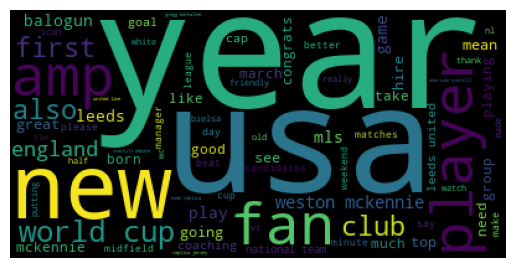

In [34]:
# Set stopwords
#nltk.download('stopwords')
sw = stopwords.words("english")

# Append non-useful words to stopwords list
appended_stopwords = ["usmnt", "would", "u", "soccer", "one", "us", "get"]
sw.extend(appended_stopwords)

# Build wordcloud of word freqs in query
wc = WordCloud(stopwords=sw).generate(" ".join(df["tweets"]))
plt.axis("off")
plt.imshow(wc)
plt.show()

### Vectorize

The vectorizer below transforms the column of clean tweets into a vector of most common words. I first convert the newly vectorized column into a dataframe, then transpose it into a term-tweet matrix. Finally, I add a column with a count of how many times each term was mentioned in the list of tweets, then print the sorted results.


In [35]:
# Initialize vectorizer
v = CountVectorizer(stop_words=sw)

# Vectorize tweets column
v_tweets = v.fit_transform(df["tweets"])

# Convert vectorized tweets into dataframe
v_tweets_df = pd.DataFrame(v_tweets.toarray(),
                          columns=v.get_feature_names_out(),
                          index=df["tweet_id"])

# Transpose it to get a term-tweet matrix
v_tweets_df = v_tweets_df.T

# Calculate frequencies of tweets for each term (row)
v_tweets_df["freq"] = v_tweets_df.sum(axis=1)

# Inspect new tweets
v_tweets_df["freq"].sort_values(ascending=False)

mckennie     11
usa          10
cup          10
year         10
leeds        10
             ..
harkes       1 
hella        1 
herzog       1 
hesitate     1 
zimmerman    1 
Name: freq, Length: 721, dtype: int64

In [36]:
# Make term into a column, select freq and term columns 
v_tweets_df["term"] = v_tweets_df.index
v_tweets_df = v_tweets_df[["freq", "term"]]

# Keep top 30 most frequent terms
v_top = v_tweets_df.sort_values(by="freq", ascending=False)[:30]

# Plot terms by frequency
alt.Chart(v_top).mark_bar().encode(alt.X("term", sort="-y"),
                                    y="freq")

alt.Chart(...)

### TextBlob Sentiment Analysis

In the code below, I leverage the TextBlob library to calculate two types of sentiment scores for each tweet: 
- Polarity (positive = 1, negative = -1) 
- Subjectivity score (completely subjective = 1, completely objective = 0)


In [41]:
# Initialize empty vector to score polarity & subjectivity scores
polarity = []
subjectivity = []

# Loop through and extract sentiment/polarity of each tweet
for i in df['tweets']:

    # Get sample polarity & subjectivity scores
    sample = TextBlob(i)
    
    # Append scores to associated vecotrs
    polarity.append(sample.sentiment[0])
    subjectivity.append(sample.sentiment[1])
    
    
# Add columns to the dataframe
df["polarity"] = polarity
df["subjectivity"] = subjectivity

# Inspect results
df[0:3]

,tweet_id,tweets,sensitive,source,retweet_count,reply_count,like_count,quote_count,impression_count,polarity,subjectivity
0,1620065740530548738,i would not include ream simply because he has played the most minutes of anyone in the epl he will need deserve a break his club will need him more for the stretch run than the usmnt in march i would bring trusty to get a look at him,False,None,0,1,0,0,3,0.333333,0.452381
1,1620065093433311232,new pod now available the pod squad returns to give updates on everything major going on in us soccer on this new episode jake tom and ellie break down mckennie transfer to shakeups at ussf matches don t miss out,False,None,1,1,1,0,134,0.115934,0.419596
2,1620064839526940673,usmnt world cup predictions for all matches in qatar a clear path to the knockout stage for christian pulisic,False,None,0,0,0,0,0,0.050000,0.191667


Additionally, I can now create custom sentiment labels (and therefore sentiment categories for my set of tweets) based on the polarity score. I do this by marking any score below 0 as negative and any score as above 0 as positive. Alternative scoring calculations could be used here as well depending (e.g. Neutral could extend from -0.10 to 0.10 or -0.05 to 0.05). This might be preferrable if you only wanted to see highly negative tweets related to a new feature or open defect that has been discovered with a product. Another option would be to create more labels like "Strongly positive", "Strongly negative", etc.


In [42]:
# Create sentiment groups based on polarity scores
df["pol_group"] = np.where(df["polarity"] > 0, "Positive",
                          np.where(df["polarity"] < 0, "Negative", "Neutral"))


# Inspect the results more closely
df_sent = df[["tweets", "pol_group", "polarity", "subjectivity"]]
df_sent

,tweets,pol_group,polarity,subjectivity
0,i would not include ream simply because he has played the most minutes of anyone in the epl he will need deserve a break his club will need him more for the stretch run than the usmnt in march i would bring trusty to get a look at him,Positive,0.333333,0.452381
1,new pod now available the pod squad returns to give updates on everything major going on in us soccer on this new episode jake tom and ellie break down mckennie transfer to shakeups at ussf matches don t miss out,Positive,0.115934,0.419596
2,usmnt world cup predictions for all matches in qatar a clear path to the knockout stage for christian pulisic,Positive,0.050000,0.191667
3,we need better players,Positive,0.500000,0.500000
4,otd one year ago capped off an incredible day for the as les rouges recorded an unforgettable victory over the in hamilton,Positive,0.850000,0.950000
...,...,...,...,...
95,world cup formal request sent to fifa for usmnt s group rivals iran to be kicked out of qatar,Neutral,0.000000,0.000000
96,so pretty much every usmnt player ever,Positive,0.225000,0.600000
97,usmnt twitter hella cringy sometimes,Neutral,0.000000,0.000000
98,should take the ball keep for your self no more great show right not half take and pass,Positive,0.229762,0.488095


### Transformers Sentiment Analysis

Using sentiment labeling for TextBlob not always the most useful method (as we can see). I'll now try an alternative approach using the transformers library.

Transformers uses pre-trained models from the most popular Python deep learning/machine learning libraries: Tensorflow, PyTorch, and Jax. I can apply these robust, well-developed models to my dataset of tweets via a process called transfer learning. 

For this example, I will apply the model to an unlabeled sentiment analysis task (i.e. calculate the sentiment of the tweets contained in my dataframe). I'll use distilBERT base uncased finetuned SST-2 model. This is one of the most widely-used, most accurate, and fastest sentiment analysis models available for this type of work.

More information regarding the model can be found on Hugging Face [here](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [43]:
model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [44]:
# Create empty vector for sentiment scores
sent_label = []
sent_confidence = []

# Apply model and extract sentiment labels/scores
for i in df_sent["tweets"]:
    sample = model(i)
    sent_label.append(sample[0]["label"])
    sent_confidence.append(sample[0]["score"])

# Append columns to df
df_sent["sent_label"] = sent_label
df_sent["sent_confidence"] = sent_confidence

In [45]:
# Inspect results (different rows this time)
df_sent.head(10)

,tweets,pol_group,polarity,subjectivity,sent_label,sent_confidence
0,i would not include ream simply because he has played the most minutes of anyone in the epl he will need deserve a break his club will need him more for the stretch run than the usmnt in march i would bring trusty to get a look at him,Positive,0.333333,0.452381,POSITIVE,0.981199
1,new pod now available the pod squad returns to give updates on everything major going on in us soccer on this new episode jake tom and ellie break down mckennie transfer to shakeups at ussf matches don t miss out,Positive,0.115934,0.419596,POSITIVE,0.970433
2,usmnt world cup predictions for all matches in qatar a clear path to the knockout stage for christian pulisic,Positive,0.050000,0.191667,POSITIVE,0.998758
3,we need better players,Positive,0.500000,0.500000,NEGATIVE,0.999296
4,otd one year ago capped off an incredible day for the as les rouges recorded an unforgettable victory over the in hamilton,Positive,0.850000,0.950000,POSITIVE,0.999700
5,bren den beat the chelsea clowns weston mckennie is all over the ground jesse s like a dog that s been beat too much tyler in midfield does the sweeping up born in the usa they were born in the usa born in the usa they were born in the usa,Positive,0.200000,0.200000,NEGATIVE,0.998918
6,vasquez is older being further behind in development means it will be very hard or damn near impossible to catch up,Negative,-0.196528,0.606250,NEGATIVE,0.999403
7,tested and trusted,Neutral,0.000000,0.000000,POSITIVE,0.998506
8,mature convo you can t go discrediting guys already playing and scoring in top leagues for someone who s older that hasn t played one minute in a top league,Positive,0.316667,0.358333,POSITIVE,0.998733
9,can they beat anyone sad to see so much poor soccer get some new blood,Negative,-0.254545,0.684848,NEGATIVE,0.998764


The labels appear to be a bit more accurate, although it is not perfect given the irregular ways in which people communicate via Twitter. The text is not nearly as clean or straightforward as a product review or an industry report, so it makes since that the model would have a more difficult time parsing and correcting classifying each tweet.

As a last step, I'll take a look at the 5 positive and negative tweets that the model was most confident in classifying. I'll also create a simple summary table to view the proportion of positive to negative tweets.

In [46]:
pd.crosstab(df_sent["sent_label"], columns="index", normalize=True)

col_0,index
sent_label,
NEGATIVE,0.5
POSITIVE,0.5


In [50]:
# Filter to positive, sort by labeling confidence, and print top 5 rows
pos_tweets = df_sent[["tweets", "sent_label", "sent_confidence"]]
pos_tweets = pos_tweets[pos_tweets["sent_label"] == "POSITIVE"].sort_values(by='sent_confidence', ascending = False)
pos_tweets[0:5]

,tweets,sent_label,sent_confidence
74,yeah he s also a really good personality strong leader looking forward to see him play love seeing so many usmnt players in the pl,POSITIVE,0.999861
4,otd one year ago capped off an incredible day for the as les rouges recorded an unforgettable victory over the in hamilton,POSITIVE,0.999700
91,i was there last night cheering you on congrats on caps,POSITIVE,0.999675
22,thanks for providing a good domain for me,POSITIVE,0.999643
31,grande,POSITIVE,0.999541


In [51]:
pd.set_option('display.width', 1000)
# Filter to negative, sort by labeling confidence, and print top 5 rows

pos_tweets = df_sent[["tweets", "sent_label", "sent_confidence"]]
pos_tweets = pos_tweets[pos_tweets["sent_label"] == "NEGATIVE"].sort_values(by='sent_confidence', ascending = False)
pos_tweets[0:5]

,tweets,sent_label,sent_confidence
34,boring game,NEGATIVE,0.999766
57,delete your account you re too dumb for this man,NEGATIVE,0.999651
79,what you losers have realize is the usmnt stinks,NEGATIVE,0.999493
70,report brian mcbride won t return as usmnt gm amid gregg berhalter probe,NEGATIVE,0.999416
6,vasquez is older being further behind in development means it will be very hard or damn near impossible to catch up,NEGATIVE,0.999403


## Conclusions

The steps I have walked through show how easy it can be to pull unstructured text data from an API, clean and process the data, transform it into a form that can be analyzed, then execute several variations of unlabeled sentiment analysis. Thanks to the open-source nature of web development, the libraries I leveraged allowed me to quickly perform these operations with relatively few lines of code.

The primary challenge in this work, however, is not running the code to apply sentiment scores or create visualizations, but in actually designing the data pipeline from the Twitter API to the models you want to run. As we can observe from some of the less accurate sentiment scores, text data (especially Twitter text data) is quite messy and difficult to analyze cleanly.

If done correctly however, this type of analysis offers incredible insights. Inquiries to customer service teams could be automatically labeled, grouped and prioritized according to their sentiment and topic-modeling results (another similar method of text analysis). Similarly, product and marketing teams could use these techniques to better understand their customers and help drive product strategy (i.e. what do we build next, what do our customers want to see). 

In my next post on this topic, I plan to bundle sentiment analysis code into a streamlit app. This would allow anyone to enter a term and see the resulting twitter sentiment analysis based on the most recent tweets. 

Thanks for reading!
